<a href="https://colab.research.google.com/github/vmkainga/Hypothesis-Testing-with-Python/blob/main/Hypothesis_Testing_Project_Violet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis Testing

## Defining the Question

You work as a data scientist for the telecom operator Megatelco. The company offers its
clients two prepaid plans, Surf and Ultimate. The commercial department wants to know
which of the plans brings in more revenue in order to adjust the advertising budget.
You are going to carry out a preliminary analysis of the plans based on a relatively small
client selection. You'll have the data on 500 Megatelco clients: who the clients are, where
they're from, which plan they use, and the number of calls they made and text messages
they sent in 2018. Your job is to analyze clients' behavior and determine which prepaid
plan brings in more revenue.

## Pre-requisites

In [ ]:
# load libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Step 1. Data Preparation

In [ ]:
#Read data

message_df=pd.read_csv("megamessage_telco.csv")

calls_df=pd.read_csv("megatelco_calls.csv")

internet_df=pd.read_csv("megatelco_internet.csv")

plans_df=pd.read_csv("megatelco_plans.csv")

users_df=pd.read_csv("megatelco_users.csv")

## Step 2. Data Cleanup

In [ ]:
#change date column datatype to date and extract month in the 3 dataframes
message_df['message_date']= pd.to_datetime(message_df['message_date'])
message_df['Month'] = message_df['message_date'].dt.month

calls_df['call_date']= pd.to_datetime(calls_df['call_date'])
calls_df['Month'] = calls_df['call_date'].dt.month


internet_df['session_date']= pd.to_datetime(internet_df['session_date'])
internet_df['Month'] = internet_df['session_date'].dt.month



In [ ]:
#drop unneccesary columns
message_df=message_df.drop(['message_date'], axis=1)
calls_df=calls_df.drop(['id', 'call_date'], axis=1)
internet_df= internet_df.drop(['id', 'session_date'], axis=1)
users_df=users_df.drop(['first_name', 'last_name', 'age', 'reg_date', 'churn_date'], axis=1)

##Step 3. Analyze data

In [ ]:
#Preview data

message_df.head()


,id,user_id,Month
0,1000_125,1000,12
1,1000_160,1000,12
2,1000_223,1000,12
3,1000_251,1000,12
4,1000_255,1000,12


In [ ]:
calls_df.head()


,user_id,duration,Month
0,1000,8.52,12
1,1000,13.66,12
2,1000,14.48,12
3,1000,5.76,12
4,1000,4.22,12


In [ ]:
internet_df.head()


,user_id,mb_used,Month
0,1000,89.86,12
1,1000,0.00,12
2,1000,660.40,12
3,1000,270.99,12
4,1000,880.22,12


In [ ]:
plans_df.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [ ]:
users_df.head()


,user_id,city,plan
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate
1,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf
2,1002,"Las Vegas-Henderson-Paradise, NV MSA",surf
3,1003,"Tulsa, OK MSA",surf
4,1004,"Seattle-Tacoma-Bellevue, WA MSA",surf


In [ ]:
#find messages sent per user per month

monthlymessage = (message_df.groupby([ 'user_id', 'Month']).count().reset_index())

monthlymessage.rename(columns={'id': 'messages'}, inplace=True)
monthlymessage


,user_id,Month,messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [ ]:
#find calls  made per user per month

monthlycalls = (calls_df.groupby([ 'user_id', 'Month']).count().reset_index())

monthlycalls

,user_id,Month,duration
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [ ]:
##find minutes used per user per month

#round off each individual call 
import math

calls_df['duration'] = calls_df['duration'].apply(np.ceil)

monthlycall_duration = (calls_df.groupby([ 'user_id', 'Month']).sum().reset_index())
monthlycall_duration



,user_id,Month,duration
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2253,1498,12,339.0
2254,1499,9,346.0
2255,1499,10,385.0
2256,1499,11,308.0


In [ ]:
#find volume of data per month
monthly_data=(internet_df.groupby([ 'user_id', 'Month']).sum().reset_index())

monthly_data['mb_used'] = (monthly_data['mb_used']/1024).apply(np.ceil)
monthly_data.rename(columns = {'mb_used':'GB_used'}, inplace = True)

monthly_data

,user_id,Month,GB_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0
...,...,...,...
2272,1498,12,23.0
2273,1499,9,13.0
2274,1499,10,20.0
2275,1499,11,17.0


In [ ]:
#merging the dataframes
data_frames = [monthlymessage, monthlycall_duration, monthly_data]
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'Month'],
                                            how='outer'), data_frames)

df_merged.head()

,user_id,Month,messages,duration,GB_used
0,1000,12,11.0,124.0,2.0
1,1001,8,30.0,182.0,7.0
2,1001,9,44.0,315.0,14.0
3,1001,10,53.0,393.0,22.0
4,1001,11,36.0,426.0,19.0


In [ ]:
#merging the dataframes

data_f = [users_df, df_merged]

df_merged2 = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'],
                                            how='outer'), data_f)

df_merged2.head()

,user_id,city,plan,Month,messages,duration,GB_used
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,12.0,11.0,124.0,2.0
1,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,8.0,30.0,182.0,7.0
2,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,9.0,44.0,315.0,14.0
3,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,10.0,53.0,393.0,22.0
4,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,11.0,36.0,426.0,19.0


In [ ]:
#replace null values to 0 and convert columns into proper datatypes

df_merged2=df_merged2.replace(np.nan, 0)

df_merged2[['Month', 'messages', 'duration', 'GB_used']] = df_merged2[['Month', 'messages', 'duration', 'GB_used']].astype(int)

df_merged2[['city', 'plan']] = df_merged2[['city', 'plan']].astype(str)

df_merged2.dtypes

user_id      int64
city        object
plan        object
Month        int64
messages     int64
duration     int64
GB_used      int64
dtype: object

In [ ]:
# rename plans_df plan column to match user_df plan column
plans_df.rename(columns={'plan_name': 'plan'}, inplace=True)

#convert mb to GB
plans_df['mb_per_month_included']=plans_df['mb_per_month_included']/1024
plans_df.rename(columns = {'mb_per_month_included':'GB_per_month_included'}, inplace = True)
plans_df


,messages_included,GB_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


In [ ]:
data_ff = [df_merged2, plans_df]

df_merged3 = reduce(lambda  left,right: pd.merge(left,right,on=['plan'],
                                            how='outer'), data_ff)
df_merged3.head(2)

,user_id,city,plan,Month,messages,duration,GB_used,messages_included,GB_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,12,11,124,2,1000,30.0,3000,70,7,0.01,0.01
1,1006,"San Francisco-Oakland-Berkeley, CA MSA",ultimate,11,15,10,3,1000,30.0,3000,70,7,0.01,0.01


In [ ]:
options = ['surf']
options2 = ['ultimate']
surf_customers = df_merged3.loc[df_merged3['plan'].isin(options)]
ultimate_customers= df_merged3.loc[df_merged3['plan'].isin(options2)]

In [ ]:
#function to calculate surf plan monthly revenue

def evaluateCharges(df1):
    
   
    df1['TotalmonthlyCharges']= df1['usd_monthly_pay']
    
    
    #performing different actions based on the conditions indicated in the question.
    
    df1.loc[df1['duration'] > 500, 'TotalmonthlyCharges'] = df1['TotalmonthlyCharges']+(df1['duration']-500)*0.03 
    
    df1.loc[df1['messages'] > 50, 'TotalmonthlyCharges']= df1['TotalmonthlyCharges']+ (df1['messages']-50)*0.03 
    
    df1.loc[df1['GB_used'] > 15, 'TotalmonthlyCharges'] = df1['TotalmonthlyCharges']+ (df1['GB_used']-15)*10 
    

    
    return df1




In [ ]:
surfmonthly_revenue_peruser=evaluateCharges(surf_customers)


In [ ]:
surfmonthly_revenue_peruser.head()

,user_id,city,plan,Month,messages,duration,GB_used,messages_included,GB_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,TotalmonthlyCharges
724,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,8,30,182,7,50,15.0,500,20,10,0.03,0.03,20.00
725,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,9,44,315,14,50,15.0,500,20,10,0.03,0.03,20.00
726,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,10,53,393,22,50,15.0,500,20,10,0.03,0.03,90.09
727,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,11,36,426,19,50,15.0,500,20,10,0.03,0.03,60.00
728,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,12,44,412,19,50,15.0,500,20,10,0.03,0.03,60.00


In [ ]:
#function to calculate ultimate plan monthly revenue
def evaluateCharges_ultimateplan(df2):
    
   
    df2['TotalmonthlyCharges']= df2['usd_monthly_pay']
    
    
    #performing different actions based on the conditions indicated in the question.
    
    df2.loc[df2['duration'] > 3000, 'TotalmonthlyCharges'] = df2['TotalmonthlyCharges'] +(df2['duration']-3000) * 0.01 
    
    df2.loc[df2['messages'] > 1000, 'TotalmonthlyCharges']= df2['TotalmonthlyCharges'] + (df2['messages']-1000) * 0.01 
    
    df2.loc[df2['GB_used'] > 30, 'TotalmonthlyCharges'] = df2['TotalmonthlyCharges'] + (df2['GB_used'] - 30) * 7 
    

    
    return df2



In [ ]:
ultimatemonthly_revenue_peruser=evaluateCharges_ultimateplan(ultimate_customers)

In [ ]:
ultimatemonthly_revenue_peruser.sample(5)

,user_id,city,plan,Month,messages,duration,GB_used,messages_included,GB_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,TotalmonthlyCharges
477,1363,"Seattle-Tacoma-Bellevue, WA MSA",ultimate,10,41,385,17,1000,30.0,3000,70,7,0.01,0.01,70
9,1011,"Cleveland-Elyria, OH MSA",ultimate,9,60,484,17,1000,30.0,3000,70,7,0.01,0.01,70
135,1077,"Charlotte-Concord-Gastonia, NC-SC MSA",ultimate,7,73,808,20,1000,30.0,3000,70,7,0.01,0.01,70
186,1128,"Knoxville, TN MSA",ultimate,9,43,18,21,1000,30.0,3000,70,7,0.01,0.01,70
583,1420,"San Francisco-Oakland-Berkeley, CA MSA",ultimate,8,2,424,18,1000,30.0,3000,70,7,0.01,0.01,70


In [ ]:
#surf plan mean


monthyusage=surfmonthly_revenue_peruser[['user_id', 'messages','duration', 'GB_used']]
monthyaverage= monthyusage.groupby([ 'user_id']).mean().reset_index()
monthyaverage.head()

,user_id,messages,duration,GB_used
0,1001,41.400000,345.600000,16.200000
1,1002,29.333333,276.333333,13.666667
2,1003,50.000000,1104.000000,27.000000
3,1004,22.125000,346.500000,19.625000
4,1005,11.000000,496.000000,17.000000


In [ ]:
#Variance, Std deviation surf
monthyusage.var()
monthyusage.std()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


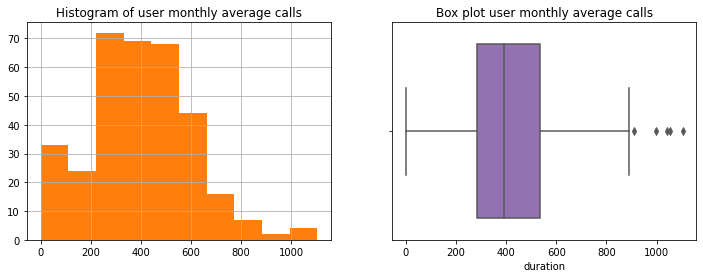

In [ ]:
#plots of distribution of average user monthly calls



fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

plt.subplot(1, 2, 1)
monthyaverage.duration.hist(color = '#ff7f0e')
plt.title('Histogram of user monthly average calls')

plt.subplot(1, 2, 2)
sns.boxplot(monthyaverage.duration, color = '#9467bd')
plt.title('Box plot user monthly average calls')

plt.show()


In [ ]:
#ultimate plan

monthyusage_ultimate=ultimatemonthly_revenue_peruser[['user_id', 'messages','duration', 'GB_used']]
monthyaverage_ultimate= monthyusage_ultimate.groupby([ 'user_id']).mean().reset_index()
monthyaverage_ultimate.head()

,user_id,messages,duration,GB_used
0,1000,11.0,124.000000,2.000000
1,1006,77.0,34.500000,17.500000
2,1008,28.0,518.666667,18.666667
3,1011,53.0,415.285714,18.857143
4,1013,16.0,219.000000,20.000000


In [ ]:
#Variance, Std deviation surf
monthyusage_ultimate.var()
monthyusage_ultimate.std()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


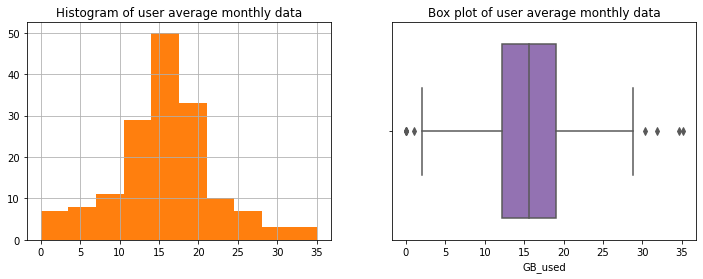

In [ ]:
#plots of distribution average user monthly data


fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

plt.subplot(1, 2, 1)
monthyaverage_ultimate.GB_used.hist(color = '#ff7f0e')
plt.title('Histogram of user average monthly data')

plt.subplot(1, 2, 2)
sns.boxplot(monthyaverage_ultimate.GB_used, color = '#9467bd')
plt.title('Box plot of user average monthly data')

plt.show()

##Step 4. Test the hypothesis
● The average revenue from users of Ultimate and Surf calling plans differs.


In [ ]:

#Null Hypothesis >> The average revenue from users of Ultimate and Surf calling plans is the similar
#Alternate Hypothesis >> The average revenue from users of Ultimate and Surf calling plans differs

revenue_ultimate=ultimatemonthly_revenue_peruser['TotalmonthlyCharges']
revenue_surf=surfmonthly_revenue_peruser['TotalmonthlyCharges']

from scipy import stats as st
import numpy as np


alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(revenue_ultimate, revenue_surf)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  1.724423314124219e-08
We reject the null hypothesis





#### ● The average revenue from users in NY-NJ area is different from that of the users from other regions.

In [ ]:
#combine the surf plan and ultimate plan records to get combined records
surfmonthly_revenue_peruser.columns = ultimatemonthly_revenue_peruser.columns
frame_combined = pd.concat([surfmonthly_revenue_peruser, ultimatemonthly_revenue_peruser], ignore_index=True)
frame_combined

In [ ]:
# Filter out records containing 'NY-NJ' in the city column
from pandas import DataFrame
options_NYNJ = frame_combined[frame_combined["city"].str.contains("NY-NJ")]
options_NYNJ.head()

In [ ]:
#drop records containing 'NY-NJ' from the main data frame to remain with other areas  records 
otherareas_df= frame_combined[frame_combined["city"].str.contains("NY-NJ")==False]
otherareas_df

In [ ]:
#Test Hypothesis

#Null Hypothesis >> The average revenue from users in NY-NJ area is similar with that of the users from other regions
#Alternate Hypothesis >> The average revenue from users in NY-NJ area is different from that of the users from other regions

revenue_NY = options_NYNJ['TotalmonthlyCharges']
revenue_other_areas=otherareas_df['TotalmonthlyCharges']

from scipy import stats as st
import numpy as np


alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(revenue_NY, revenue_other_areas)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  0.04974528277407551
We reject the null hypothesis


##5. Conclusion

a.  Surf plan brings in more revenue

b. The average revenue from users of Ultimate and Surf calling plans differs

c.The average revenue from users in NY-NJ area is different from that of the users from other regions
